In [1]:
# READ DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from google.colab import files
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import tensorflow as tf
import random

# Import Data

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]
data = data.iloc[972:1215].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   30/08/2024  10.000000
1   31/08/2024  10.000000
2   01/09/2024  10.000000
3   02/09/2024  10.833333
4   03/09/2024  10.000000
    Daily_Period  TMA_Daily
238   25/04/2025  20.000000
239   26/04/2025  20.000000
240   27/04/2025  20.000000
241   28/04/2025  21.666667
242   29/04/2025  20.000000


In [4]:
print(data.describe())

        TMA_Daily
count  243.000000
mean    20.084869
std     10.850430
min     10.000000
25%     10.000000
50%     20.000000
75%     24.166667
max     80.833333


# Eksplorasi Data

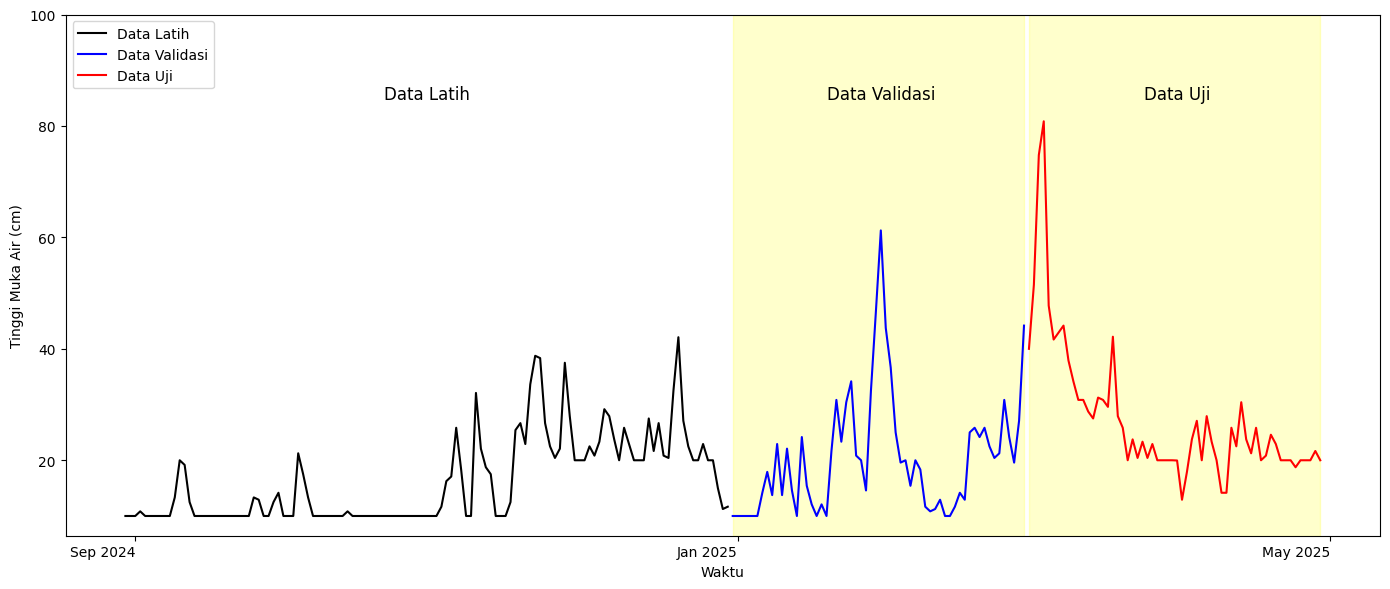

Dimensi Data Latih: (123, 2)
Dimensi Data Validasi: (60, 2)
Dimensi Data Uji: (60, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
import pandas as pd

# Konversi tanggal
data['Daily_Period'] = pd.to_datetime(data['Daily_Period'], format='%d/%m/%Y')

# Pemisahan data
train_data = data.iloc[:123]
val_data = data.iloc[123:183]
test_data = data.iloc[183:]

# Plot
plt.figure(figsize=(14, 6))

plt.plot(train_data['Daily_Period'], train_data['TMA_Daily'], label='Data Latih', color='black')
plt.plot(val_data['Daily_Period'], val_data['TMA_Daily'], label='Data Validasi', color='blue')
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'], label='Data Uji', color='red')

# Highlight area validasi dan uji
plt.axvspan(val_data['Daily_Period'].iloc[0],
            val_data['Daily_Period'].iloc[-1],
            color='yellow', alpha=0.2)
plt.axvspan(test_data['Daily_Period'].iloc[0],
            test_data['Daily_Period'].iloc[-1],
            color='yellow', alpha=0.2)

# Tambahkan label sumbu dan judul
plt.xlabel('Waktu')
plt.ylabel('Tinggi Muka Air (cm)')
# plt.title('Plot Data Latih, Validasi, dan Uji')
plt.ylim(top=100)

# Format dan tampilan waktu di sumbu x
plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=[1, 5, 9]))
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate(rotation=0)

# Tambahkan teks label di atas area masing-masing
plt.text(train_data['Daily_Period'].iloc[len(train_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Latih', ha='center', fontsize=12)
plt.text(val_data['Daily_Period'].iloc[len(val_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Validasi', ha='center', fontsize=12)
plt.text(test_data['Daily_Period'].iloc[len(test_data)//2],
         data['TMA_Daily'].max() * 1.05,
         'Data Uji', ha='center', fontsize=12)

# Tampilkan legenda dan plot
plt.legend()
plt.tight_layout()
plt.show()

# Cetak dimensi
print('Dimensi Data Latih:', train_data.shape)
print('Dimensi Data Validasi:', val_data.shape)
print('Dimensi Data Uji:', test_data.shape)

# Hyperparameter Tuning LSTM

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.initializers import HeUniform

In [7]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Menentukan ukuran dataset
train_size = 123
val_size = 60
test_size = len(time_series_data) - train_size - val_size

# Membagi data menjadi train, val, test
train_data = time_series_data[:train_size]
val_data = time_series_data[train_size:train_size+val_size]
test_data = time_series_data[train_size+val_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu
seq_length = 30

# Membuat dataset sekuens
X_train = create_sequences(train_data, seq_length)
X_val = create_sequences(val_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]

y_val = X_val[:, -1]
X_val = X_val[:, :-1]

y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshape untuk input LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Fungsi untuk membuat model LSTM
def create_model():
    optimizer = Adam(learning_rate=0.005)
    model = Sequential()
    model.add(LSTM(
        50,
        activation='tanh',
        input_shape=(seq_length - 1, 1),
        kernel_initializer=GlorotUniform(),
        recurrent_initializer=GlorotUniform(),
        bias_initializer='zeros'
    ))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Fungsi menghitung AIC
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

# Inisialisasi model
model = create_model()

# List nilai AIC tiap epoch
aic_values = []

# Epoch yang akan diuji
epochs_to_test = [10, 50, 100, 150, 200, 250]

# Training dan evaluasi dengan AIC menggunakan data validasi (bukan test)
for epoch in epochs_to_test:
    model.fit(X_train, y_train, epochs=epoch, batch_size=128, verbose=0,
              validation_data=(X_val, y_val))

    # Prediksi pada data validasi (bukan test!)
    y_pred = model.predict(X_val)

    # Hitung MSE dan AIC
    mse = mean_squared_error(y_val, y_pred)
    n = len(y_val)
    num_params = model.count_params()  # jumlah parameter trainable
    aic = calculate_aic(n, mse, num_params)

    aic_values.append(aic)
    print(f"Epoch {epoch} - AIC: {aic}")

# Menampilkan hasil
print("AIC untuk setiap epoch yang diuji:", aic_values)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Epoch 10 - AIC: 20792.791641495773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 50 - AIC: 20780.723706753124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 100 - AIC: 20765.421222738947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 150 - AIC: 20789.108083617688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 200 - AIC: 20795.543457413805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 250 - AIC: 20801.698236408087
AIC untuk setiap epoch yang diuji: [np.float64(20792.791641495773), np.float64(20780.723706753124), np.float64(20765.421222738947), np.float64(20789.108083617688), np.float64(20795.543457413805), np.float64(20801.698236408087)]


In [8]:
print(X_train)

[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.04705882]
  [0.04117647]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.01176471]
  ...
  [0.04117647]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.01176471]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.03529412]]

 ...

 [[0.25294118]
  [0.14117647]
  [0.14117647]
  ...
  [0.14117647]
  [0.18235294]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.14117647]
  ...
  [0.18235294]
  [0.14117647]
  [0.14117647]]

 [[0.14117647]
  [0.14117647]
  [0.17647059]
  ...
  [0.14117647]
  [0.14117647]
  [0.07058824]]]


In [9]:
print(X_val)

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.05294118]
  [0.17058824]
  [0.06470588]
  [0.        ]
  [0.2       ]
  [0.07647059]
  [0.02941176]
  [0.        ]
  [0.02941176]
  [0.        ]
  [0.16470588]
  [0.29411765]
  [0.18823529]
  [0.28823529]
  [0.34117647]
  [0.15294118]
  [0.14117647]
  [0.06470588]
  [0.31764706]
  [0.51764706]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.05882353]
  [0.11176471]
  [0.05294118]
  [0.18235294]
  [0.0

# LSTM Final

In [10]:
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Membangun model LSTM dengan aktivasi tanh dan init_scheme glorot_uniform
optimizer = Adam(learning_rate=0.005)  # Learning Rate Best Params
model = Sequential()
model.add(LSTM(
    50,
    activation='tanh',  # Fungsi aktivasi
    input_shape=(seq_length - 1, 1),
    kernel_initializer=GlorotUniform(),        # Init untuk input
    recurrent_initializer=GlorotUniform(),     # Init untuk recurrent (hidden)
    bias_initializer='zeros'                   # Bias default nol
))
model.add(Dropout(0.01))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Melatih model dengan data validasi (bukan test)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=10
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

# Prediksi dengan Model LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


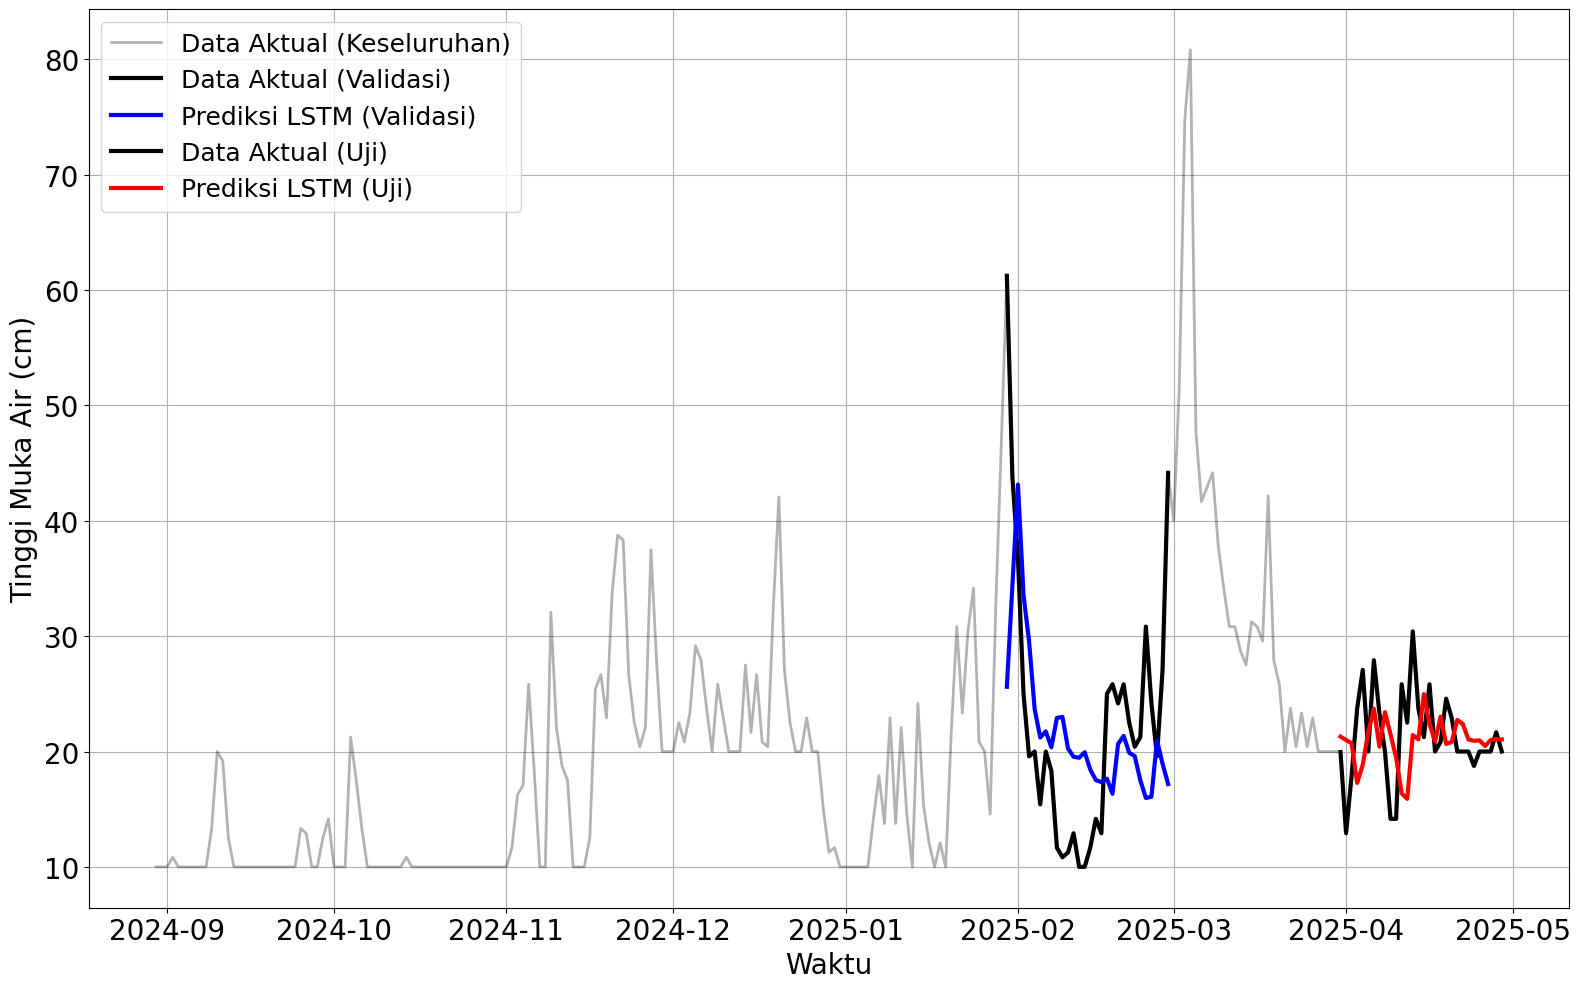

In [11]:
# Prediksi pada data validasi
pred_val = model.predict(X_val)
inv_val = scaler.inverse_transform(np.concatenate((X_val[:, -1], pred_val.reshape(-1, 1)), axis=1))[:, 1]

# Prediksi pada data uji
pred_test = model.predict(X_test)
inv_test = scaler.inverse_transform(np.concatenate((X_test[:, -1], pred_test.reshape(-1, 1)), axis=1))[:, 1]

# Menentukan index waktu yang sesuai
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

plt.figure(figsize=(16, 10))

# 1. Plot keseluruhan data aktual (train + val + test)
plt.plot(data['Daily_Period'], data['TMA_Daily'].values,
         lw=2, label='Data Aktual (Keseluruhan)', color='black', alpha=0.3)

# 2. Plot data aktual validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         data['TMA_Daily'].values[val_start_idx:val_end_idx],
         lw=3, label='Data Aktual (Validasi)', color='black')

# 3. Plot prediksi validasi
plt.plot(data['Daily_Period'][val_start_idx:val_end_idx],
         inv_val, lw=3, label='Prediksi LSTM (Validasi)', color='blue')

# 4. Plot data aktual uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         data['TMA_Daily'].values[test_start_idx:test_end_idx],
         lw=3, label='Data Aktual (Uji)', color='black')

# 5. Plot prediksi uji
plt.plot(data['Daily_Period'][test_start_idx:test_end_idx],
         inv_test, lw=3, label='Prediksi LSTM (Uji)', color='red')

# Label dan format
plt.xlabel('Waktu', fontsize=20)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=20)
plt.legend(loc = 'upper left', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Prediksi Model LSTM pada Data Validasi dan Uji', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

# Nilai MAPE (Testing)

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

# Indeks awal dan akhir validasi
val_start_idx = train_size + seq_length
val_end_idx = val_start_idx + len(inv_val)

# Indeks awal dan akhir uji
test_start_idx = train_size + val_size + seq_length
test_end_idx = test_start_idx + len(inv_test)

# MAPE Validasi (%)
mape_val = mean_absolute_percentage_error(
    data['TMA_Daily'].values[val_start_idx:val_end_idx],
    inv_val
) * 100

# MAPE Uji (%)
mape_test = mean_absolute_percentage_error(
    data['TMA_Daily'].values[test_start_idx:test_end_idx],
    inv_test
) * 100

# Tampilkan hasil dengan 2 desimal
print(f'MAPE Validasi: {mape_val:.2f}%')
print(f'MAPE Uji     : {mape_test:.2f}%')

MAPE Validasi: 40.64%
MAPE Uji     : 17.50%


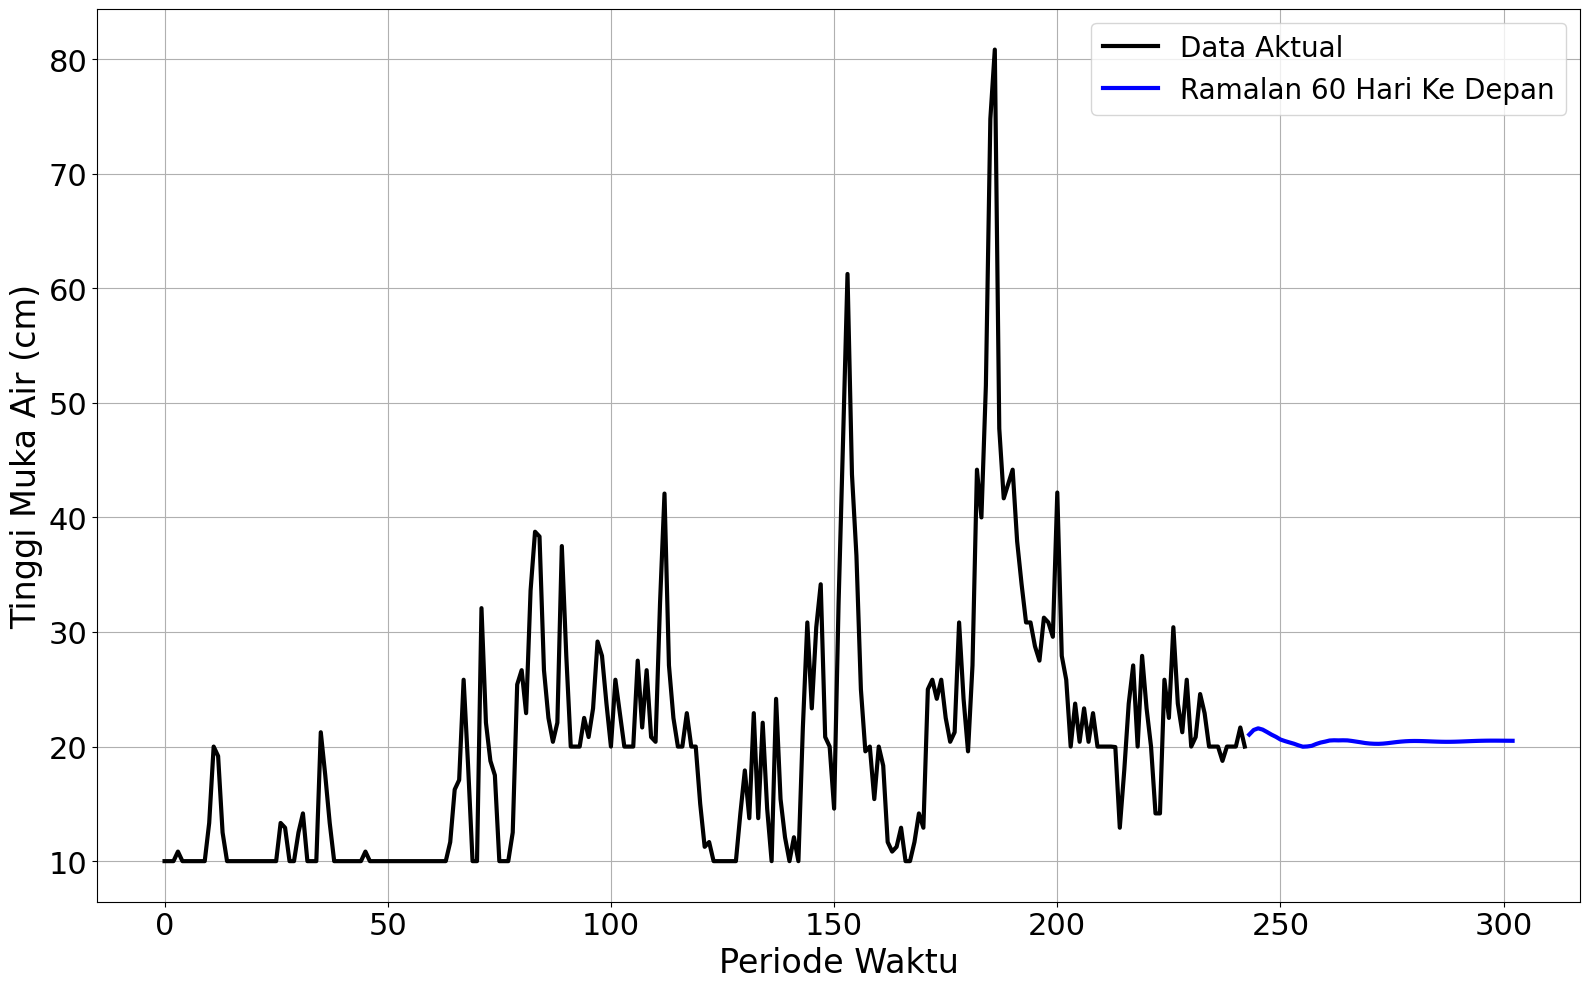

In [13]:
# Menentukan jumlah langkah ke depan yang ingin diramalkan
future_steps = 60

# Menggunakan data terakhir dari data uji sebagai input awal (tanpa target)
future_data = X_test[-1]  # Bentuk: (seq_length - 1, 1)

# Menyimpan hasil prediksi
future_predictions = []

for i in range(future_steps):
    # Prediksi 1 langkah ke depan
    prediction = model.predict(future_data.reshape(1, seq_length - 1, 1), verbose=0)
    future_predictions.append(prediction[0, 0])

    # Perbarui input untuk prediksi berikutnya
    future_data = np.append(future_data[1:], prediction[0])  # geser & tambahkan prediksi baru
    future_data = future_data.reshape(seq_length - 1, 1)

# Invers transform hasil prediksi ke skala asli (cm)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualisasi gabungan data aktual + hasil ramalan
plt.figure(figsize=(16, 10))

# 1. Data aktual (Train + Val + Test) dalam skala asli
plt.plot(np.arange(len(time_series_data)),
         scaler.inverse_transform(time_series_data),
         lw=3, label='Data Aktual', color='black')

# 2. Hasil prediksi ke depan (setelah akhir data uji)
plt.plot(np.arange(len(time_series_data), len(time_series_data) + future_steps),
         future_predictions, lw=3, label='Ramalan 60 Hari Ke Depan', color='blue')

# Label dan tampilan
plt.legend(fontsize=20)
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.title('Peramalan 60 Hari Ke Depan Menggunakan Model LSTM', fontsize=22)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Mengubah hasil prediksi masa depan menjadi DataFrame
future_predictions = pd.DataFrame(future_predictions, columns=['Prediksi_TMA'])

# Tampilkan hasil prediksi ke depan
print(future_predictions)

# Simpan hasil prediksi ke file Excel
future_predictions.to_excel("lstm_forecast_futurepred_3way_split.xlsx", index=False)

    Prediksi_TMA
0      21.047338
1      21.448656
2      21.592102
3      21.480846
4      21.265532
5      21.039934
6      20.845871
7      20.613907
8      20.479961
9      20.362778
10     20.250099
11     20.109488
12     19.988346
13     20.009663
14     20.065062
15     20.224945
16     20.351326
17     20.432335
18     20.528164
19     20.548737
20     20.539356
21     20.547981
22     20.538429
23     20.490063
24     20.430172
25     20.370750
26     20.306597
27     20.265488
28     20.243319
29     20.238480
30     20.259039
31     20.297394
32     20.344973
33     20.392651
34     20.433538
35     20.463671
36     20.481812
37     20.487919
38     20.484571
39     20.474628
40     20.460936
41     20.445719
42     20.431143
43     20.420204
44     20.414530
45     20.415609
46     20.422953
47     20.434994
48     20.450310
49     20.466579
50     20.481882
51     20.495207
52     20.505760
53     20.512901
54     20.516562
55     20.517141
56     20.515247
57     20.5118

# Plot Forecasting

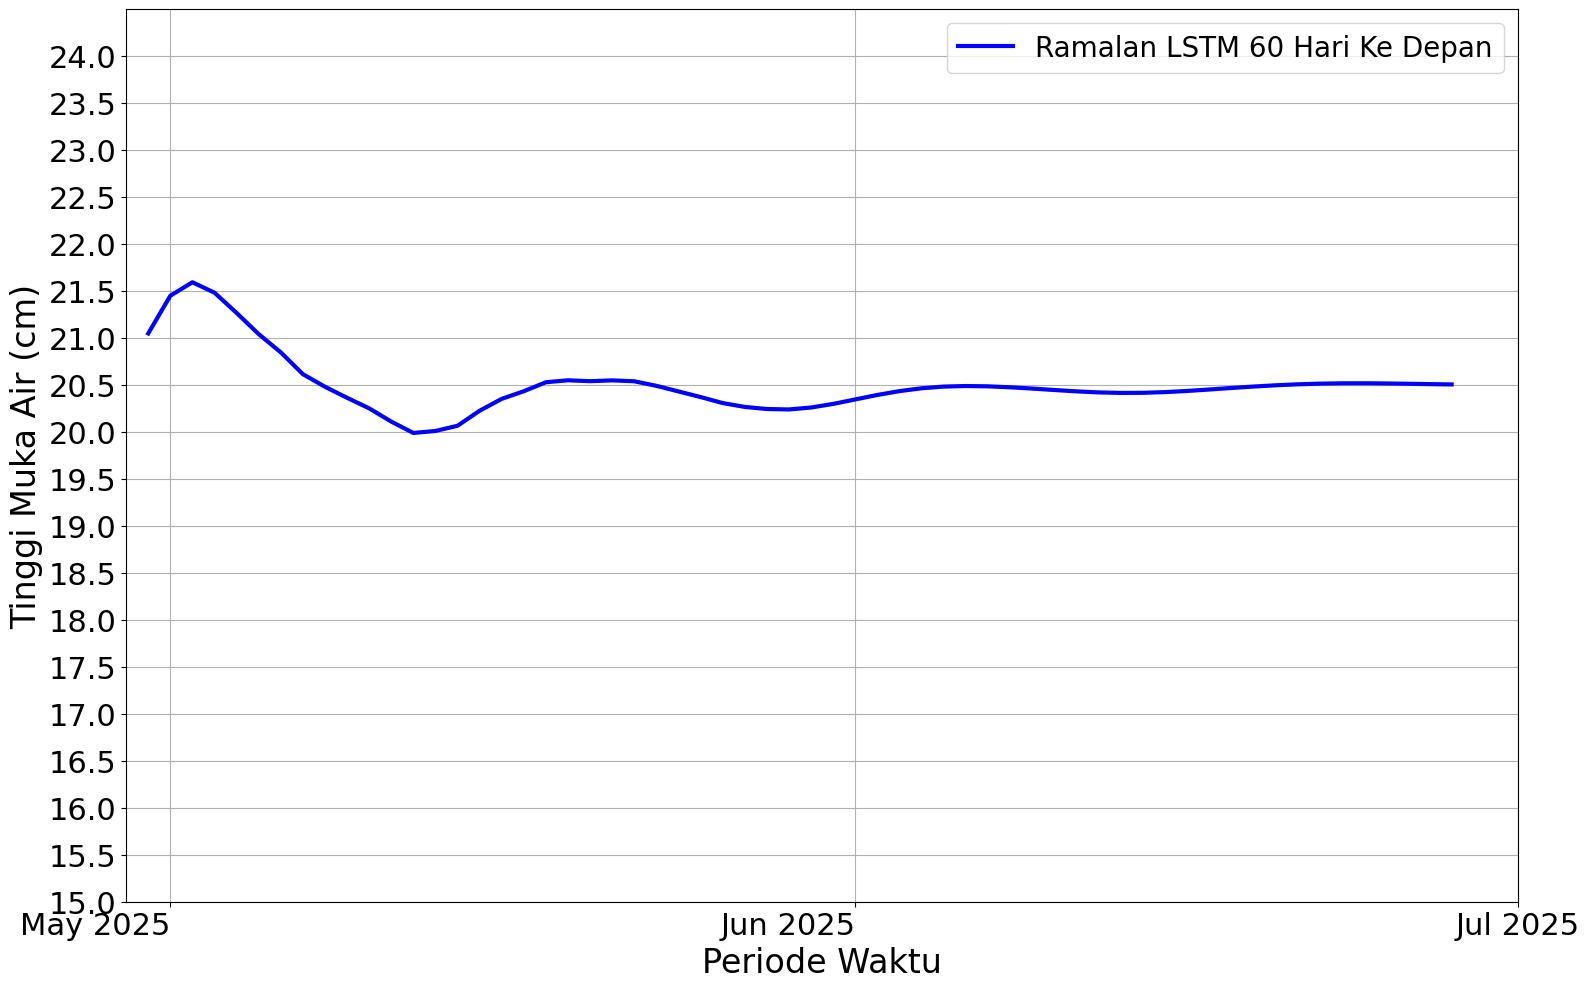

In [15]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Generate future dates starting from the day after the last date in the original data
last_date = data['Daily_Period'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Visualisasi hasil prediksi ke depan (tanpa data aktual)
plt.figure(figsize=(16, 10))
plt.plot(future_dates, future_predictions, lw=3, label='Ramalan LSTM 60 Hari Ke Depan', color='blue')

# Label sumbu dan ukuran font
plt.xlabel('Periode Waktu', fontsize=24)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(np.arange(15, 24.5, 0.5), fontsize=22)
plt.ylim(top=24.5)

# Format label tanggal pada sumbu X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas akhir tampilan waktu prediksi
end_date = pd.to_datetime('2025-07-01')
plt.xlim(last_date, end_date)

# Tambahkan grid dan legend
plt.grid(True)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

# Plot Test vs Aktual vs Forecast

In [16]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Revisi%20Analisis/Data%20TMA%20(Jan%202022%20-%20Juni%202025).csv')
data = data.loc[:, ['Daily_Period', 'TMA_Daily']]

data = data.iloc[:1275].reset_index(drop=True)

print(data.head())
print(data.tail())

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1270   24/06/2025  15.000000
1271   25/06/2025  15.416667
1272   26/06/2025  10.000000
1273   27/06/2025  10.000000
1274   28/06/2025  15.833333


Jumlah data uji: 60
Jumlah data aktual forecast: 60
Tanggal awal prediksi: 2025-04-30 00:00:00
Tanggal akhir prediksi: 2025-06-28 00:00:00


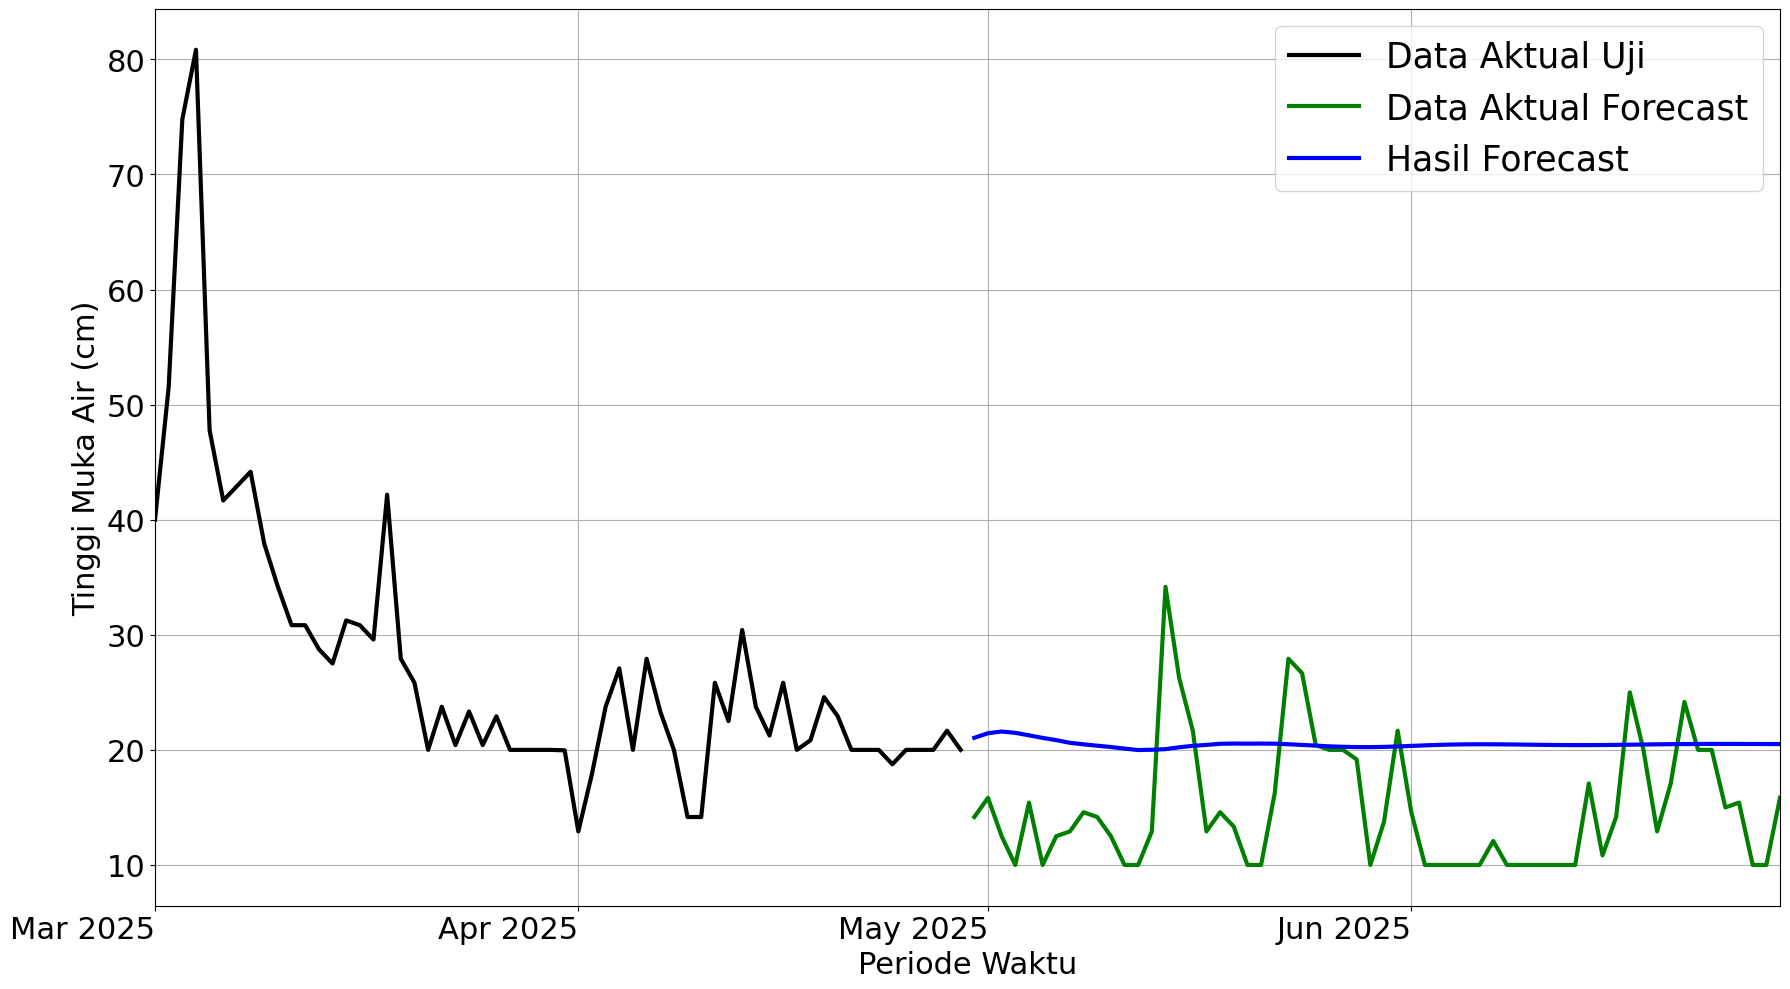

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_full = data.iloc[:1275].reset_index(drop=True)
# Ubah kolom tanggal ke format datetime
data_full['Daily_Period'] = pd.to_datetime(data_full['Daily_Period'], dayfirst=True)

# --- DEFINISI PERIODE ---
test_start = pd.to_datetime('01/03/2025', dayfirst=True)
test_end = pd.to_datetime('29/04/2025', dayfirst=True)

forecast_actual_start = pd.to_datetime('30/04/2025', dayfirst=True)
forecast_actual_end = pd.to_datetime('28/06/2025', dayfirst=True)

# --- FILTER DATA ---
test_data = data_full[(data_full['Daily_Period'] >= test_start) & (data_full['Daily_Period'] <= test_end)]
actual_forecast_data = data_full[(data_full['Daily_Period'] >= forecast_actual_start) & (data_full['Daily_Period'] <= forecast_actual_end)]

# --- CEK DATA ---
print("Jumlah data uji:", len(test_data))
print("Jumlah data aktual forecast:", len(actual_forecast_data))
print("Tanggal awal prediksi:", future_dates[0])
print("Tanggal akhir prediksi:", future_dates[-1])

# --- (Opsional) Inverse transform jika belum ---
try:
    future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()
except:
    pass

# --- PLOT ---
plt.figure(figsize=(18, 10))

# 1. Plot Data Test
plt.plot(test_data['Daily_Period'], test_data['TMA_Daily'],
         color='black', linewidth=3, label='Data Aktual Uji')

# 2. Plot Data Aktual Forecast
plt.plot(actual_forecast_data['Daily_Period'], actual_forecast_data['TMA_Daily'],
         color='green', linewidth=3, label='Data Aktual Forecast')

# 3. Plot Forecasting
plt.plot(future_dates, future_predictions,
         color='blue', linewidth=3, label='Hasil Forecast')

# --- FORMAT PLOT ---
plt.xlabel('Periode Waktu', fontsize=22)
plt.ylabel('Tinggi Muka Air (cm)', fontsize=22)
# plt.title('Perbandingan Data Uji, Aktual Forecast, dan Hasil Forecasting', fontsize=24)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=25)
plt.grid(True)

# Atur format tanggal: tampilkan bulan dan tahun (misal: Mar 2025)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Tampilkan label setiap awal bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Putar label tanggal agar tidak saling tumpang tindih
plt.gcf().autofmt_xdate(rotation=0)

# Atur batas waktu agar sumbu X mencakup Maret–Juli 2025
plt.xlim(test_start, future_dates[-1])
plt.tight_layout()
plt.show()